In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
import pooch

In [3]:
GCM_name_allk = [
    "ACCESS1-0_r1i1p1",
    "ACCESS1-3_r1i1p1",
    "CESM1-BGC_r1i1p1",
    "CMCC-CMS_r1i1p1",
    "CMCC-CM_r1i1p1",
    "HadGEM2-CC_r1i1p1",
    "IPSL-CM5B-LR_r1i1p1",
    "inmcm4_r1i1p1",
]

GCM_name_all = [
    "BNU-ESM_r1i1p1",
    "CCSM4_r1i1p1",
    "CSIRO-Mk3-6-0_r1i1p1",
    "GFDL-ESM2G_r1i1p1",
    "CanESM2_r1i1p1",
    "GFDL-ESM2M_r1i1p1",
    "IPSL-CM5A-LR_r1i1p1",
    "IPSL-CM5A-MR_r1i1p1",
    "MIROC-ESM-CHEM_r1i1p1",
    "MIROC-ESM_r1i1p1",
    "MIROC5_r1i1p1",
    "MPI-ESM-MR_r1i1p1",
    "MRI-CGCM3_r1i1p1",
    "bcc-csm1-1-m_r1i1p1",
    "bcc-csm1-1_r1i1p1",
]

In [4]:
def read_url(gcm, s):
    url = (
        "https://github.com/IPCC-WG1/Atlas/raw/main/datasets-aggregated-regionally/data/CMIP5/CMIP5_tas_landsea/CMIP5_"
        + gcm
        + "_"
        + s
        + ".csv"
    )
    print(url)
    csv_file = pooch.retrieve(url=url, known_hash=None)
    df = pd.read_csv(csv_file, index_col=0, header=15)
    return df

In [5]:
def yearmean(df, where):
    df["date"] = pd.to_datetime(df["date"])
    dfy = df.groupby(df["date"].dt.year)[where].mean()

    t = dfy.to_frame()
    dfy = t.rename(
        columns={"world": "temperature"}
    )  # nicht mehr individueller Name sonder einfach gcm
    return dfy

In [6]:
def deviation(df):
    # calculate deviation from pre-industrial

    sel = df.query("date >= 1850 and date <= 1900")
    # mean undependend of NaN
    PI_mean = sel["temperature"].mean(skipna=True)  # wie im atlas

    dfn = df.copy()
    dfn["temperature"] = dfn["temperature"] - PI_mean
    # print(dfn.head())
    return dfn

In [7]:
def runningmean(df):
    # calculate running mean:

    df_running = df.rolling(30, center=True).mean()
    return df_running

In [8]:
# Listen Erstellen:
GCM_name_rcp85 = [
    "MPI-ESM-LR_r1i1p1",
    "HadGEM2-ES_r1i1p1",
    "EC-EARTH_r12i1p1",
    "CNRM-CM5_r1i1p1",
    "NorESM1-M_r1i1p1",
    "IPSL-CM5A-MR_r1i1p1",
    "MIROC5_r1i1p1",
    "CanESM2_r1i1p1",
]
GCM_name_rcp45 = [
    "HadGEM2-ES_r1i1p1",
    "EC-EARTH_r12i1p1",
    "CNRM-CM5_r1i1p1",
    "NorESM1-M_r1i1p1",
    "MPI-ESM-LR_r1i1p1",
    "IPSL-CM5A-MR_r1i1p1",
]

GCM_name_rcp26 = [
    "MPI-ESM-LR_r1i1p1",
    "HadGEM2-ES_r1i1p1",
    "EC-EARTH_r12i1p1",
    "CNRM-CM5_r1i1p1",
    "NorESM1-M_r1i1p1",
    "MIROC5_r1i1p1",
    "IPSL-CM5A-LR_r1i1p1",
    "GFDL-ESM2G_r1i1p1",
]

In [9]:
def read_GCM_file(where):
    df = pd.DataFrame()

    sce = ["rcp85", "rcp45", "rcp26"]

    for s in sce:
        # I only read the gcm-file which have been used in EURO-CORDEX as forcing
        if s == "rcp26":
            liste = GCM_name_rcp26
        elif s == "rcp45":
            liste = GCM_name_rcp45
        else:
            liste = GCM_name_rcp85

        for gcm in liste:
            # read input
            dfs = read_url(gcm, s)
            dfh = read_url(gcm, "historical")

            dft = pd.concat([dfs, dfh])
            dft = dft.reset_index()

            # calculate year mean
            dfy = yearmean(dft, where)

            # calculate deviation from pre-industrial
            dfd = deviation(dfy)

            # calculate running mean
            rdf = runningmean(dfd)

            # add more information for easier plotting:
            rdf["gcm"] = gcm
            rdf["scenario"] = s

            df = pd.concat([df, rdf], axis=0)

    df = df.reset_index()
    return df

In [10]:
def read_GCM_file_all(where):
    df = pd.DataFrame()

    sce = ["rcp85", "rcp45", "rcp26"]
    scek = ["rcp85", "rcp45"]  # , "rcp26"]

    for s in sce:
        # read all which are not in CORDEX

        liste = GCM_name_all
        # print(liste)

        for gcm in liste:
            # read input
            dfs = read_url(gcm, s)
            dfh = read_url(gcm, "historical")

            dft = pd.concat([dfs, dfh])
            dft = dft.reset_index()

            # calculate year mean
            dfy = yearmean(dft, where)

            # calculate deviation from pre-industrial
            dfd = deviation(dfy)

            # calculate running mean
            rdf = runningmean(dfd)

            # add more information for easier plotting:
            rdf["gcm"] = gcm
            rdf["scenario"] = s

            df = pd.concat([df, rdf], axis=0)

    for s in scek:
        # read all which are not in CORDEX

        liste = GCM_name_allk
        # print(liste)

        for gcm in liste:
            # read input
            dfs = read_url(gcm, s)
            dfh = read_url(gcm, "historical")

            dft = pd.concat([dfs, dfh])
            dft = dft.reset_index()

            # calculate year mean
            dfy = yearmean(dft, where)

            # calculate deviation from pre-industrial
            dfd = deviation(dfy)

            # calculate running mean
            rdf = runningmean(dfd)

            # add more information for easier plotting:
            rdf["gcm"] = gcm
            rdf["scenario"] = s

            df = pd.concat([df, rdf], axis=0)
    df = df.reset_index()
    return df

In [11]:
def save(df, out):
    print("Output will be in =", out)
    df.to_csv(out, na_rep="NaN")

In [12]:
# name of output data frame, which will be save for later:
name = "df_ipcc_temperature_deviation_PI_30y_runningmean_world.csv"
workdir = os.getcwd()
out = os.path.join(workdir, name)

# design dataframe:
# chose world, could also be an other region ("NEU","WCE","MED".....)

df = read_GCM_file("world")
save(df, out)

https://github.com/IPCC-WG1/Atlas/raw/main/datasets-aggregated-regionally/data/CMIP5/CMIP5_tas_landsea/CMIP5_MPI-ESM-LR_r1i1p1_rcp85.csv
https://github.com/IPCC-WG1/Atlas/raw/main/datasets-aggregated-regionally/data/CMIP5/CMIP5_tas_landsea/CMIP5_MPI-ESM-LR_r1i1p1_historical.csv
https://github.com/IPCC-WG1/Atlas/raw/main/datasets-aggregated-regionally/data/CMIP5/CMIP5_tas_landsea/CMIP5_HadGEM2-ES_r1i1p1_rcp85.csv
https://github.com/IPCC-WG1/Atlas/raw/main/datasets-aggregated-regionally/data/CMIP5/CMIP5_tas_landsea/CMIP5_HadGEM2-ES_r1i1p1_historical.csv
https://github.com/IPCC-WG1/Atlas/raw/main/datasets-aggregated-regionally/data/CMIP5/CMIP5_tas_landsea/CMIP5_EC-EARTH_r12i1p1_rcp85.csv
https://github.com/IPCC-WG1/Atlas/raw/main/datasets-aggregated-regionally/data/CMIP5/CMIP5_tas_landsea/CMIP5_EC-EARTH_r12i1p1_historical.csv
https://github.com/IPCC-WG1/Atlas/raw/main/datasets-aggregated-regionally/data/CMIP5/CMIP5_tas_landsea/CMIP5_CNRM-CM5_r1i1p1_rcp85.csv
https://github.com/IPCC-WG1/At

In [13]:
# name of output data frame, which will be save for later:
name = "df_ipcc_temperature_deviation_PI_30y_runningmean_world_all.csv"
out = os.path.join(workdir, name)

# design dataframe:
# chose world, could also be an other region ("NEU","WCE","MED".....)

dfa = read_GCM_file_all("world")
save(dfa, out)

https://github.com/IPCC-WG1/Atlas/raw/main/datasets-aggregated-regionally/data/CMIP5/CMIP5_tas_landsea/CMIP5_BNU-ESM_r1i1p1_rcp85.csv
https://github.com/IPCC-WG1/Atlas/raw/main/datasets-aggregated-regionally/data/CMIP5/CMIP5_tas_landsea/CMIP5_BNU-ESM_r1i1p1_historical.csv
https://github.com/IPCC-WG1/Atlas/raw/main/datasets-aggregated-regionally/data/CMIP5/CMIP5_tas_landsea/CMIP5_CCSM4_r1i1p1_rcp85.csv
https://github.com/IPCC-WG1/Atlas/raw/main/datasets-aggregated-regionally/data/CMIP5/CMIP5_tas_landsea/CMIP5_CCSM4_r1i1p1_historical.csv
https://github.com/IPCC-WG1/Atlas/raw/main/datasets-aggregated-regionally/data/CMIP5/CMIP5_tas_landsea/CMIP5_CSIRO-Mk3-6-0_r1i1p1_rcp85.csv
https://github.com/IPCC-WG1/Atlas/raw/main/datasets-aggregated-regionally/data/CMIP5/CMIP5_tas_landsea/CMIP5_CSIRO-Mk3-6-0_r1i1p1_historical.csv
https://github.com/IPCC-WG1/Atlas/raw/main/datasets-aggregated-regionally/data/CMIP5/CMIP5_tas_landsea/CMIP5_GFDL-ESM2G_r1i1p1_rcp85.csv
https://github.com/IPCC-WG1/Atlas/ra

In [14]:
# read HadCRU
Dir = "/work/ch0636/eddy/pool/obs/cru/HadCRUT5"
file = "HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv"
dfname = os.path.join(Dir, file)
df_had = pd.read_csv(dfname)
sel = df_had.query("Time >= 1850 and Time <= 1900")
PI_mean = sel["Anomaly (deg C)"].mean()
dfn = df_had.copy()
dfn["Anomaly (deg C)"] = dfn["Anomaly (deg C)"] - PI_mean
dfn["scenario"] = "Observation"
dfn["gcm"] = "HadCRUT.5"
# dfn

In [15]:
def read_hadcru(url):
    print(url)
    csv_file = pooch.retrieve(url=url, known_hash=None)
    df = pd.read_csv(csv_file)
    return df

In [16]:
url_had = "https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/analysis/diagnostics/HadCRUT.5.0.2.0.analysis.summary_series.global.annual.csv"
df_had = read_hadcru(url_had)
sel = df_had.query("Time >= 1850 and Time <= 1900")
PI_mean = sel["Anomaly (deg C)"].mean()
dfn = df_had.copy()
dfn["Anomaly (deg C)"] = dfn["Anomaly (deg C)"] - PI_mean
dfn["scenario"] = "HadCRUT"
dfn["gcm"] = "HadCRUT.5"

https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/analysis/diagnostics/HadCRUT.5.0.2.0.analysis.summary_series.global.annual.csv


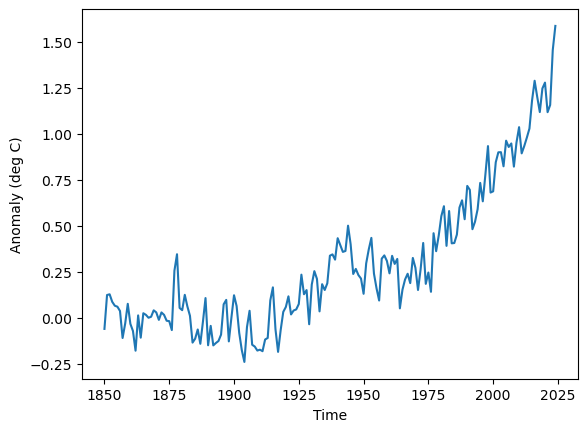

In [17]:
fig = sns.lineplot(data=dfn, x="Time", y="Anomaly (deg C)")

## make plot

Plot saved:  /work/ch0636/g300047/GITHUB/climate-action-sheet-forestry/Notebooks/cmip_HadCRUt5_GWL_all_deutsch.png


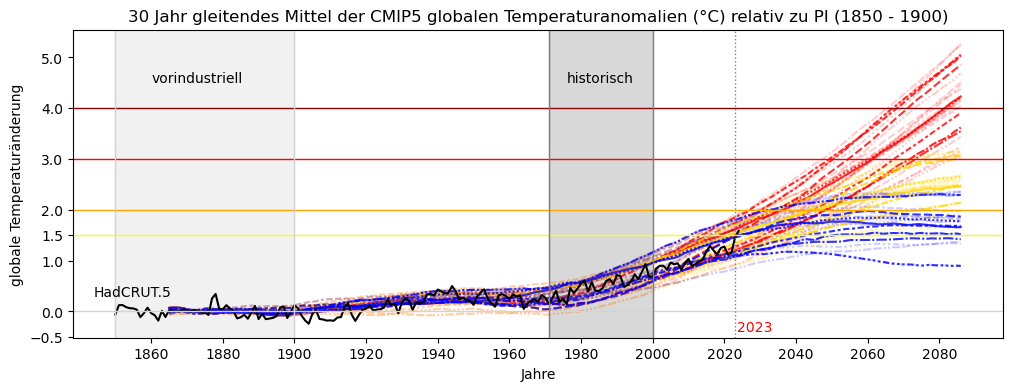

In [18]:
rcp_color = {
    "rcp26": "b",
    "rcp45": "gold",
    "rcp85": "r",
    "HadCRUT": "k",
    "all": "tab:grey",
}

fig, ax = plt.subplots(figsize=(12, 4))

fig = sns.lineplot(
    data=dfa,
    x="date",
    y="temperature",
    hue="scenario",  # "rest",
    palette=rcp_color,
    style="gcm",
    alpha=0.2,
    estimator=None,
)
fig.get_legend().remove()
fig = sns.lineplot(
    data=df,
    x="date",
    y="temperature",
    hue="scenario",
    palette=rcp_color,
    style="gcm",
    alpha=0.8,
)
fig = sns.lineplot(
    data=dfn, x="Time", y="Anomaly (deg C)", hue="scenario", palette=rcp_color
)
# styling
fig.axhline(1.5, color="yellow", linestyle="-", linewidth=1)
fig.axhline(2, color="orange", linestyle="-", linewidth=1)
fig.axhline(3, color="red", linestyle="-", linewidth=1)
fig.axhline(4, color="darkred", linestyle="-", linewidth=1)
fig.axhline(0, color="lightgrey", linestyle="-", linewidth=1)
fig.axvline(2023, color="grey", linestyle=":", linewidth=1)
fig.text(2023.5, -0.4, "2023", color="r", fontsize=10)
fig.text(1844, 0.3, "HadCRUT.5", color="k", fontsize=10)
fig.set_ylabel("globale Temperaturänderung")
fig.set_xlabel("Jahre")
fig.set_title(
    "30 Jahr gleitendes Mittel der CMIP5 globalen Temperaturanomalien (°C) relativ zu PI (1850 - 1900)"
)

fig.set_yticks([-0.5, 0, 1, 1.5, 2, 3, 4, 5])
fig.set_xticks([1860, 1880, 1900, 1920, 1940, 1960, 1980, 2000, 2020, 2040, 2060, 2080])

fig.axvline(1971, color="grey", linestyle="-", linewidth=1)
fig.axvline(2000, color="grey", linestyle="-", linewidth=1)
fig.axvspan(1971, 2000, ymin=-0.6, ymax=1, alpha=0.3, color="grey")

fig.axvline(1850, color="lightgrey", linestyle="-", linewidth=1)
fig.axvline(1900, color="lightgrey", linestyle="-", linewidth=1)
fig.axvspan(1850, 1900, ymin=-0.6, ymax=1, alpha=0.3, color="lightgrey")
fig.text(1860, 4.5, "vorindustriell", fontsize=10)
fig.text(1976, 4.5, "historisch", fontsize=10)

# Legend at the bottom
sns.move_legend(
    fig,
    "lower center",
    bbox_to_anchor=(0.5, -1),
    ncol=4,
    title=None,
    frameon=False,
)
# Wenn die legende stört
ax.get_legend().remove()

# plt.show()

plotname = os.path.join(workdir, "cmip_HadCRUt5_GWL_all_deutsch.png")

plt.savefig(plotname, bbox_inches="tight")
print("Plot saved: ", plotname)

## PLOT: GCM-CORDEX

The darker colors are the GCMs used as forcing in Cordex the lighter colors are all GCMs